# Melodic Exploration of Single Recording Pitch Contour
March 2021

Two approaches to automated characteristic melodic pattern discovery in pitch tracks of Indian Art Music using performances from the Carnatic Saraga Collection as downloaded via MIRDATA - https://github.com/mir-dataset-loaders/mirdata

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')

from src.recording.obj import Recording, compute_distance_matrix, cluster_dist_matrix
from src.visualisation import plot_all_sequences, double_timeseries
from src.utils import detect_local_minima, get_timestamp, get_minima, search_and_cluster, interpolate_below_length 
from src.io import write_all_sequence_audio, write_json

In [2]:
from src.utils import interpolate_below_length

## Load Recording

Path to recording directory in `mir_datasets/saraga_carnatic/saraga1.5_carnatic/`

In [3]:
performance_path = '/Users/thomasnuttall/mir_datasets/saraga_carnatic/saraga1.5_carnatic/Live at Kamarajar Hall by Sanjay Subrahmanyan/Kamakshi/'

In [4]:
# Interpolate 0 pitch gaps shorter than or equal to <gap_interp> seconds
gap_interp = 200*0.001 # 60ms
rec = Recording(performance_path, gap_interp=gap_interp)

[2021-03-11 20:50:33,735] WARNING [src.recording.obj.__init__:81] No isolated vocal pitch track using mix instead


In [5]:
raaga = rec.raaga
arohana = rec.arohana
avorahana = rec.avorahana
tonic = rec.tonic
length = get_timestamp(rec.times[-1], " ")

In [6]:
print(f'Raaga: {raaga}')
print(f'Arohana: {arohana}')
print(f'Avorahana: {avorahana}')
print(f'Tonic: {tonic} Hz')
print(f'Performance Length: {length}')

Raaga: Bhairavi
Arohana: ['S', 'R2', 'G2', 'M1', 'P', 'D2', 'N2', 'S']
Avorahana: ['S', 'N2', 'D1', 'P', 'M1', 'G2', 'R2', 'S']
Tonic: 146.832384 Hz
Performance Length: 20min 23.92sec


## Melodic Exploration

Two methods of identifying repeated patterns in pitch contour time series:
- **Method 1 - Minimum in Matrix Profile + Subsequence Search**
    - Compute self-similarity Matrix Profile (MP) of pitch contour
    - Identify minimas in MP
    - Query entire pitch contour with patterns identified at minimas
    - Return those matches with a distance below some threshold
    - Number of characteristic subsequences == Number of minimas found in MP
- **Method 2 - Distance Matrix + Clustering**
    - Compute entire pitch contour self similarity matrix
    - For memory purposes, pairs of subsequences that do not match the following are discarded:
        - Proportion if non-silence above some threshold
        - Similarity within top N percent of similarities
    - DBSCAN [2] sparse clustering to identify clusters of subsequences [unsupervised]
    - DBSCAN applied again to group identical subsequences within a cluster (i.e. subsequences which are out of phase by a timestep)
    - Number of characteristic subsequences == Number of clusters returned by DBSCAN

Both rely on the Stumpy [1] matrix profiling package, using z-normalised euclidean distance for similarity.

[1] https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html
[2] https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

### Method 1 - Minimum in Matrix Profile + Subsequence Search

#### 1.1 Compute Matrix Profile

In [59]:
m_secs = 7.0 # subsequence length in seconds
smooth = 10 # sigmma for gaussian smoothing before MP

In [60]:
mp = rec.self_matrix_profile(m=m_secs, smooth=smooth, cache=True)

First 87.0 seconds of pitch and matrix profile


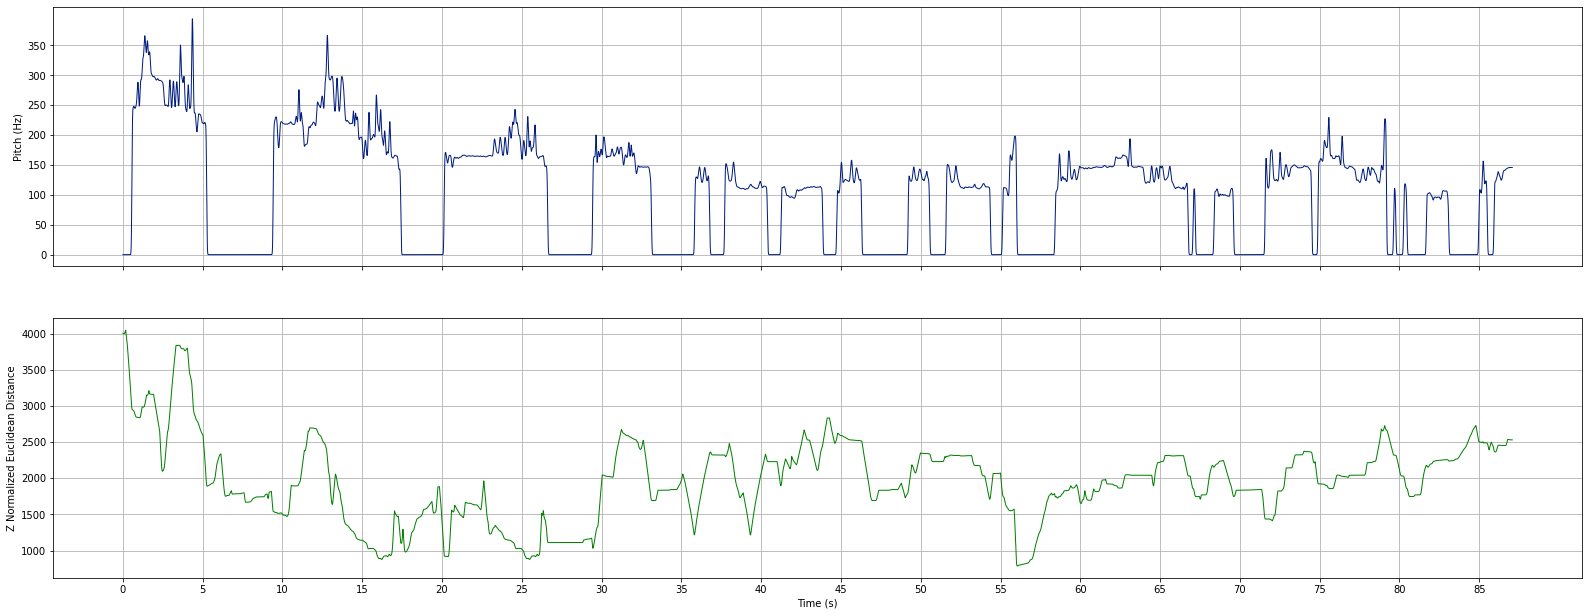

In [61]:
sam = 30000
print(f'First {sam*0.0029} seconds of pitch and matrix profile')
fig, ax = double_timeseries(
    rec.times[:sam], rec.pitch_smoothed[:sam], mp[:, 0][:sam], y1label='Pitch (Hz)', 
    y2label='Z Normalized Euclidean Distance', xlabel='Time (s)')

#### 1.2 Identify Minima

In [62]:
# bottom <sig_percentile> % of MP values in minimas are considered
# ...after silence filtering
sig_percentile = 20
# For minima clustering
bandwidth = m_secs/(2*0.0029)
remove_silent = True
minima = get_minima(rec, mp, m_secs, sig_percentile, bandwidth=bandwidth, remove_silent=remove_silent)
print(f'{len(minima)} minimas found (after filtering)')

8 minimas found (after filtering)


#### 1.3 Subsequence Search for Minima

In [63]:
N = 10 # number of subsequence occurences to return for each motif group
all_seqs, importances = search_and_cluster(minima, rec, m_secs, N=N)

#### 1.4 Output

Write plots for all subsequences

In [64]:
direc = f'../output/kamakshi/20210312/m={m_secs}__sig_percentile={sig_percentile}__remove_silent={str(remove_silent)}__bandwidth={int(bandwidth)}__smooth={str(smooth)}/'
plot_kwargs = {
    'yticks_dict':rec.svara_freq,
    'cents':True,
    'tonic':rec.tonic,
    'emphasize':['S'],
    'figsize':(10,4)#,
    #'ylim':(0, 1400)
}

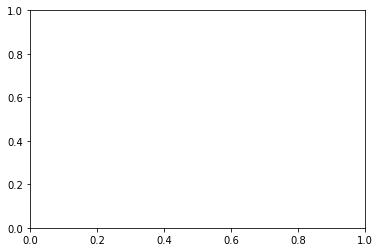

In [65]:
plot_all_sequences(rec, m_secs, all_seqs, direc, importances=importances, clear_dir=True, plot_kwargs=plot_kwargs)

Write audio for all subsequences

In [66]:
write_all_sequence_audio(rec.audio_path, all_seqs, m_secs, direc)

/Users/thomasnuttall/.virtualenvs/iam/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Write run metadata

In [67]:
metadata = {
    'raaga': raaga,
    'arohana': arohana,
    'avorahana': avorahana,
    'tonic': f'{round(tonic, 2)} Hz',
    'performance_length': length,
    'pitch_track_path': rec.pitch_vocal_path if rec.pitch_vocal_path else rec.pitch_mix_path,
    'audio_path': rec.audio_path,
    'subsequence_length': f'{m_secs} s',
    'interpolated_gap_length': f'{gap_interp} s',
    'KDE_bandwidth': round(bandwidth,2),
    'silent_subsequences_removed?': remove_silent,
    'num_motifs_discovered': len(all_seqs),
    'number_of_returned_motifs_for_each_group': N if N else 'automatic',
    'percentile_top_motifs': f'{sig_percentile}%',
    'gaussian_smoothing_sigma': smooth if smooth else 'No smoothing'
}
write_json(metadata, os.path.join(direc, 'metadata.json'))

In [68]:
print(f'All plots, audio, importances and metadata written to {direc}')

All plots, audio, importances and metadata written to ../output/kamakshi/20210312/m=7.0__sig_percentile=20__remove_silent=True__bandwidth=1206__smooth=10/


### Method 2 - Distance Matrix + Clustering

#### 2.1 Compute Distances

<font color='red'>**Warning**</font> - very time intensive step

In [ ]:
filt_perc = 0.5 # Top <filt_perc> percentile to accept before considering
m_secs = 3 # Subsequence length in seconds
nonzero_perc = 0.50 # Percentage of subsequence to be non zero before considering
filepath = os.path.join(rec.rec_dir, 'distance_mat_generous.csv')

In [ ]:
compute_distance_matrix(rec, filt_perc, m_secs, nonzero_perc, filepath)

#### 2.2 Cluster Sequences

In [ ]:
# Load distance matrix
mat_name = 'distance_mat.csv'
filepath = os.path.join(rec.rec_dir, mat_name)
dist_data = np.genfromtxt(filepath, delimiter=',')

In [ ]:
eps = 20 # epsilon for DBSCAN in dist matrix
intra_eps = 100 # epsilon for DBSCAN on grouping neighbouring sequences
min_n_clust = 2 # minimum number of occurences of subsequence

In [ ]:
out_seq = cluster_dist_matrix(dist_data, eps, intra_eps, min_n_clust)

In [ ]:
print(f'{len(out_seq)} repeated patterns found')

#### 2.3 Plot Characteristic Subsequence Groups

In [ ]:
direc = f'../plots/chintayama_kanda/mining/{mat_name}/20210303_eps={eps}/'
plot_kwargs = {
    'yticks_dict':rec.svara_freq,
    'cents':True,
    'tonic':rec.tonic,
    'emphasize':['S'], 
    'figsize':(10,4)#,
    #'ylim':(0, 1400)
}
m_secs = 3 # Subsequence length in seconds

In [ ]:
plot_all_sequences(rec, m_secs, out_seq, direc, clear_dir=True, plot_kwargs=plot_kwargs)